I wonder how easy it would be to do a basic simulation of the human vocal system, where the user manipulates the positions of the tongue / lips / vocal cords to create different sounds. My first instinct is that I might need a few more degrees before I can do this, but let's see!

Before I jump into research, I have a few ideas for how to make it work:
1. Record (or synthesize) a bunch of constant mouth noises, and interpolate between them based on mouth position. 
    - Pros:
        - No messing around with wave shapes.
        - Easy to visualize.
    - Cons:
        - May not produce very human sounds.
        - Not as cool as generating the audio from scratch.
        - *Might* not work.
    - Questions:
        - What exactly would you interpolate? My first thought is to interpolate the fft amplitudes. I'd expect that to cause two wave shapes to kind of meet in the middle.

    

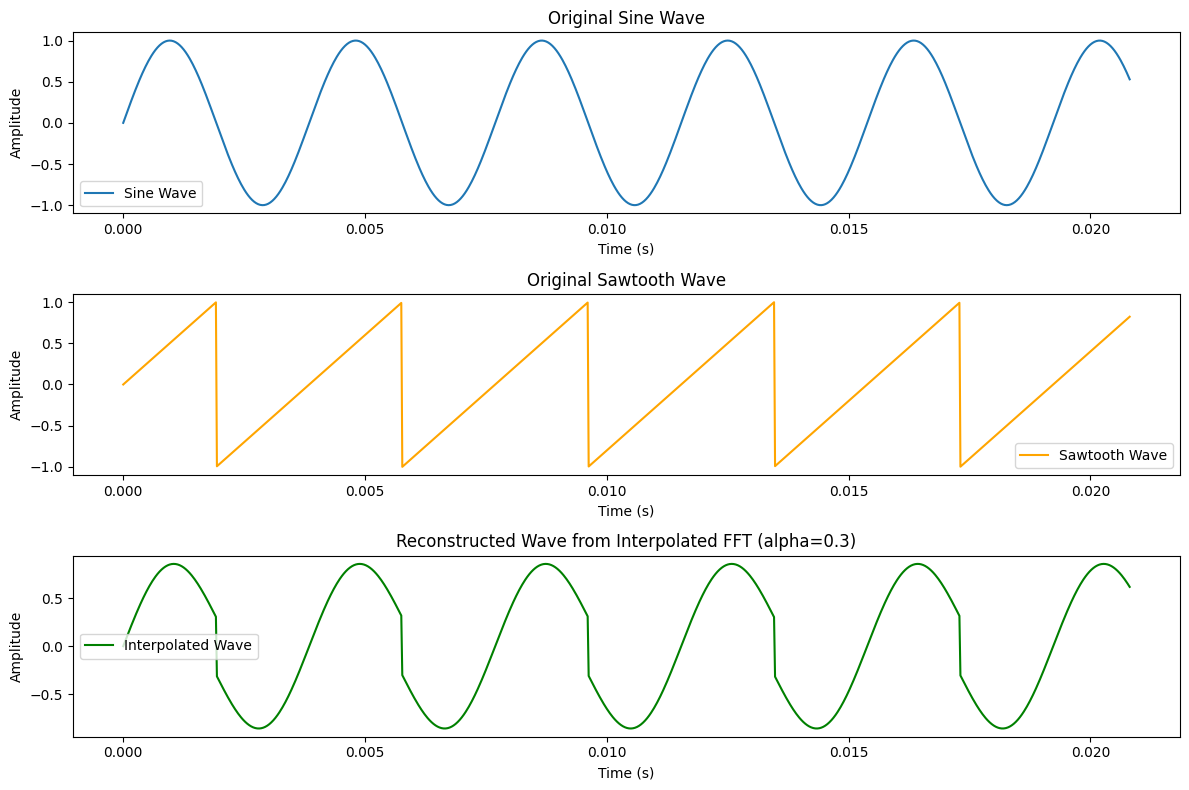

Play the Sine Wave:


Play the Sawtooth Wave:


Play the Interpolated Wave:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d
from IPython.display import Audio, display


def interpolate_audio(
    wave1: np.ndarray, wave2: np.ndarray, alpha: float, sample_rate: int
) -> np.ndarray:
    """
    Interpolates between two audio signals in the frequency domain based on a factor alpha.

    Parameters:
        wave1 (np.ndarray): First waveform (e.g., "aaa").
        wave2 (np.ndarray): Second waveform (e.g., "ooo").
        alpha (float): Interpolation factor; 0 returns wave1, 1 returns wave2.
        sample_rate (int): Sampling rate of the audio signals.

    Returns:
        np.ndarray: Time-domain signal of the interpolated waveform.
    """
    # Perform FFT on both waves
    fft_wave1 = fft(wave1)
    fft_wave2 = fft(wave2)
    fft_freqs = fftfreq(len(wave1), 1 / sample_rate)

    # Interpolate FFT magnitudes with adjustable alpha
    interp_func_wave1 = interp1d(
        fft_freqs, fft_wave1, kind="linear", fill_value="extrapolate"
    )
    interp_func_wave2 = interp1d(
        fft_freqs, fft_wave2, kind="linear", fill_value="extrapolate"
    )
    interpolated_fft = alpha * interp_func_wave2(fft_freqs) + (
        1 - alpha
    ) * interp_func_wave1(fft_freqs)

    # Reconstruct the interpolated signal in the time domain using the inverse FFT
    interpolated_wave = ifft(interpolated_fft).real
    return interpolated_wave


# Constants
sample_rate = 48000  # Samples per second
duration = 1.0  # Duration in seconds
freq = 260.0  # Frequency of the sine and sawtooth waves
alpha = 0.3  # Interpolation factor

# Generate sine wave and sawtooth wave
t = np.linspace(0.0, duration, int(sample_rate * duration), endpoint=False)
sine_wave = np.sin(2 * np.pi * freq * t)
sawtooth_wave = 2 * (t * freq - np.floor(1 / 2 + t * freq))

# Use interpolate_audio to blend sine and sawtooth waves
interpolated_wave = interpolate_audio(sine_wave, sawtooth_wave, alpha, sample_rate)

# Plot the original waves and the resulting interpolated wave
plt.figure(figsize=(12, 8))

# Original Sine Wave
plt.subplot(3, 1, 1)
plt.plot(t[:1000], sine_wave[:1000], label="Sine Wave")
plt.title("Original Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Original Sawtooth Wave
plt.subplot(3, 1, 2)
plt.plot(t[:1000], sawtooth_wave[:1000], label="Sawtooth Wave", color="orange")
plt.title("Original Sawtooth Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Interpolated Wave (Reconstructed)
plt.subplot(3, 1, 3)
plt.plot(t[:1000], interpolated_wave[:1000], label="Interpolated Wave", color="green")
plt.title(f"Reconstructed Wave from Interpolated FFT (alpha={alpha})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Display audio controls
print("Play the Sine Wave:")
display(Audio(sine_wave, rate=sample_rate))

print("Play the Sawtooth Wave:")
display(Audio(sawtooth_wave, rate=sample_rate))

print("Play the Interpolated Wave:")
display(Audio(interpolated_wave, rate=sample_rate))

Wow that actually worked way better than I thought it would! I would bet, however, that the effect sort of breaks down when you use more complex tones. Well, we're already on the tangent so we might as well see it through.

In [8]:
# Assuming "aaa.wav" and "ooo.wav" are generated and available in the current directory
import soundfile as sf

# Load the "aaa" and "ooo" audio files
aaa_wave, _ = sf.read("aaa.wav", dtype="float32")
ooo_wave, _ = sf.read("ooo.wav", dtype="float32")

# Ensure both waveforms are the same length for interpolation
min_len = min(len(aaa_wave), len(ooo_wave))
aaa_wave = aaa_wave[:min_len]
ooo_wave = ooo_wave[:min_len]

for a in range(5):
    alpha = a / 5
    # Interpolate between "aaa" and "ooo" sounds
    interpolated_vocal_wave = interpolate_audio(
        aaa_wave, ooo_wave, alpha=alpha, sample_rate=sample_rate
    )
    # Play the interpolated audio
    print(f"Alpha = {alpha:.2f}:")
    display(Audio(interpolated_vocal_wave, rate=sample_rate))
print(f"Alpha = 1:")
display(Audio(ooo_wave, rate=sample_rate))

Alpha = 0.00:


Alpha = 0.20:


Alpha = 0.40:


Alpha = 0.60:


Alpha = 0.80:


Alpha = 1:


Well that didn't work! It just sounds like a chorus!

Now that I think about it though, that does make sense. Playing to sounds together just adds their waves together, and interpolating by dividing by two just halves the overall amplitude. So, the halfway point between the two sounds would just sound like both sounds at half volume.

Ok! Time for some actual research. 